# Zone 237 — Visualizations & EDA

**Objective**  
Explore **intra–Zone 237** trip behavior visually: temporal patterns, duration distributions, spatial pickup/dropoff density, and OSM-based route features. Optionally, compare **model predictions vs. actuals** and visualize residuals/calibration to guide downstream modeling.

**What this notebook does**  
- Loads prepared Zone 237 dataset (and optional predictions)  
- Produces temporal charts (by hour/day), duration hist/box/violin plots  
- Maps pickup/dropoff density (hexbin/KDE) and overlays key streets  
- Summarizes OSM route features (length, time, highway types, lanes)  
- (Optional) Plots predictions vs. truth, residuals by bucket, and calibration curves  
- Saves figures/tables for reports and slides

---

## Inputs

- **`npz/intra_zone_trips_237_osm_features.npz`** → pandas DataFrame  
  - Required columns (dtypes):  
    - `trip_duration_minutes` — `float` (minutes)  
    - `pickup_datetime` — `datetime64[ns]`  
    - `gen_pu_lat`, `gen_pu_lon`, `gen_do_lat`, `gen_do_lon` — `float` (WGS84)  
    - `route_len_m` — `float` (meters), `route_time_min` — `float` (minutes)  
    - Optional: `duration_cluster` (`category`), `pu_highway`/`do_highway` (`str`), `pu_lanes`/`do_lanes` (`float`)
- **Optional predictions file** 
  - CSV/Parquet with columns:  
    - `trip_id` (if available), `y_true` (`float`, minutes), `y_pred` (`float`, minutes)  
    - Optional: `pi_low`, `pi_high` (`float`) for interval coverage; any join key to merge with the main DataFrame

---

## Outputs

- **Figures** (PNG/SVG in `figs/`):  
  - `figs/zone237_duration_hist.png` — duration distribution  
  - `figs/zone237_duration_by_hour.png` — box/violin by pickup hour  
  - `figs/zone237_spatial_hexbin.png` — pickup density map  
  - `figs/zone237_route_features.png` — route length/time summaries  
- **Interactive maps** (optional Folium HTML in `maps/`):  
  - `maps/zone237_pickup_density.html`

In [2]:
import npz_io
df = npz_io.load_df_npz("npz/intra_zone_trips_237_osm_features.npz")

In [11]:
# df.info()

In [7]:
import pandas as pd
import numpy as np

df = df.copy()

# Ensure route length in km
if "route_length_km" not in df.columns:
    if "route_len_m" in df.columns:
        df["route_length_km"] = df["route_len_m"] / 1000.0
    elif "straight_km" in df.columns:
        df["route_length_km"] = df["straight_km"]
    else:
        raise ValueError("Need route_len_m or straight_km to compute route_length_km.")

# Basic column sanity
required = ["pickup_datetime", "route_length_km", "trip_duration_minutes", "hour_of_day", "day_of_week"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

# Zone-237 filtering using available zone column
zone_col = "pickup_zone" if "pickup_zone" in df.columns else ("PUlocationID" if "PUlocationID" in df.columns else None)

if zone_col is not None:
    # implied speed (km/h) based on route_length_km and reported duration
    df["implied_kph"] = df["route_length_km"] / (df["trip_duration_minutes"] / 60.0)

    before_count = len(df)
    df = df[~(
        (df[zone_col].astype("Int64") == 237) &
        (
            (df["trip_duration_minutes"] < 1) |
            (df["trip_duration_minutes"] > 180) |
            (df["implied_kph"] > 120)
        )
    )].copy()
    after_count = len(df)
    print(f"Filtered zone 237 trips using '{zone_col}': {before_count - after_count} removed, {after_count} remain.")
else:
    print("No pickup zone column found ('pickup_zone' or 'PUlocationID'); skipping zone-based filtering.")

# Datetime + essentials 
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors="coerce")
df = df.dropna(subset=["pickup_datetime", "route_length_km", "trip_duration_minutes"]).copy()

# Hour of week
df["hour_of_week"] = df["day_of_week"] * 24 + df["hour_of_day"]

# Duration labels
if "duration_cluster" in df.columns:
    df["duration_label"] = df["duration_cluster"].astype("category")
else:
    q1 = df["trip_duration_minutes"].quantile(1/3)
    q2 = df["trip_duration_minutes"].quantile(2/3)
    def _dur_lab(m):
        if m <= q1: return "short"
        if m <= q2: return "medium"
        return "long"
    df["duration_label"] = df["trip_duration_minutes"].apply(_dur_lab).astype("category")

print(df["duration_label"].value_counts(dropna=False).sort_index())


Filtered zone 237 trips using 'PUlocationID': 0 removed, 3414 remain.
duration_label
short_trip     1183
medium_trip    1656
long_trip       515
Name: count, dtype: int64


Histograms for Distance and Duration

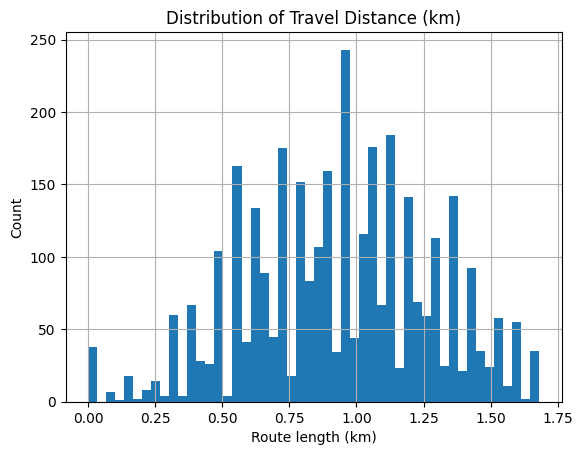

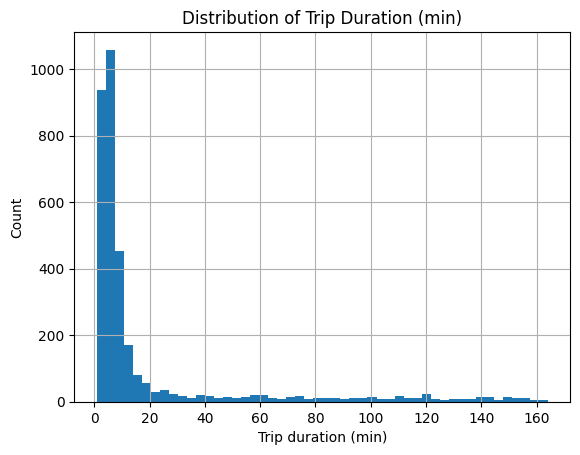

In [9]:
import matplotlib.pyplot as plt

p99_dist = df["route_length_km"].quantile(0.99)
p99_dur  = df["trip_duration_minutes"].quantile(0.99)

plt.figure()
df.loc[df["route_length_km"]<=p99_dist, "route_length_km"].hist(bins=50)
plt.title("Distribution of Travel Distance (km)")
plt.xlabel("Route length (km)"); plt.ylabel("Count")
plt.show()

plt.figure()
df.loc[df["trip_duration_minutes"]<=p99_dur, "trip_duration_minutes"].hist(bins=50)
plt.title("Distribution of Trip Duration (min)")
plt.xlabel("Trip duration (min)"); plt.ylabel("Count")
plt.show()

Scatter Checks by Label (Distance vs Time)

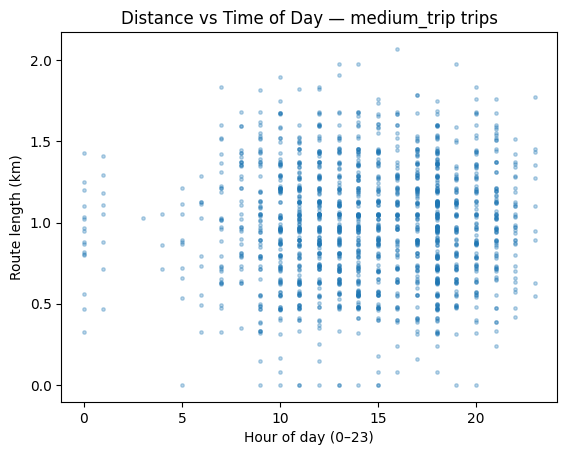

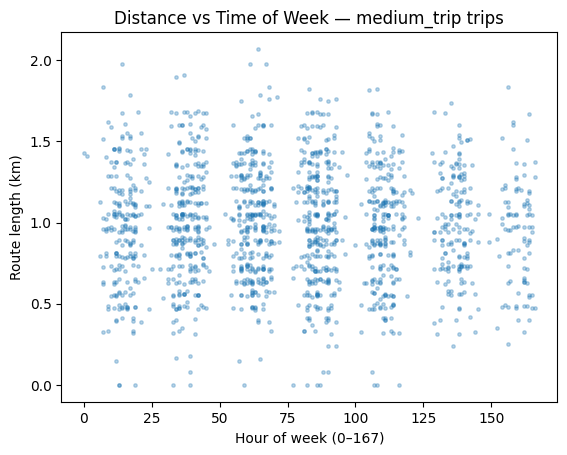

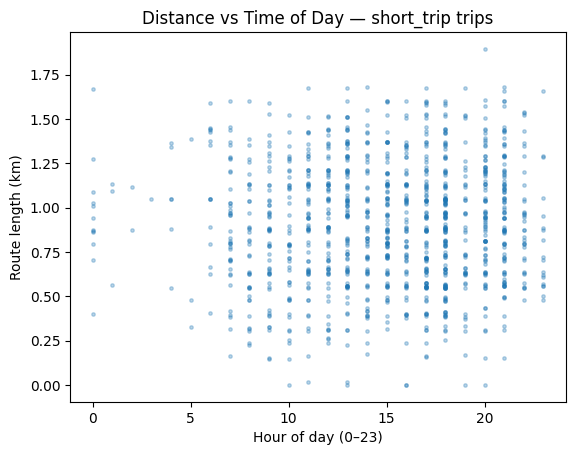

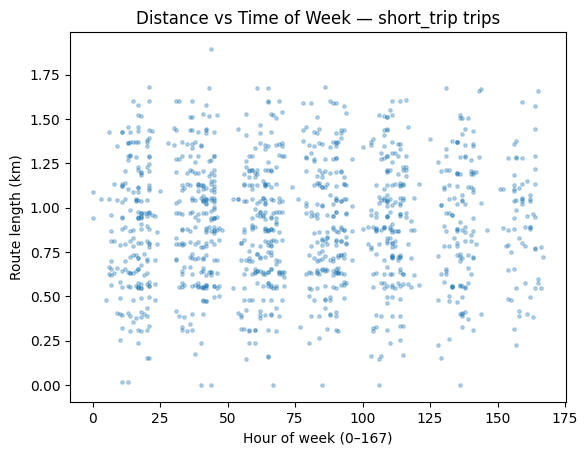

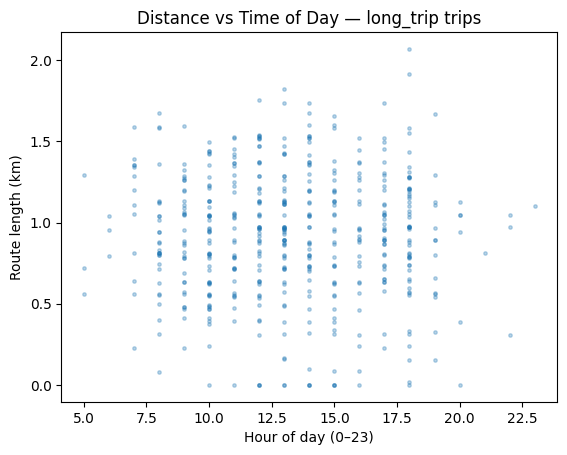

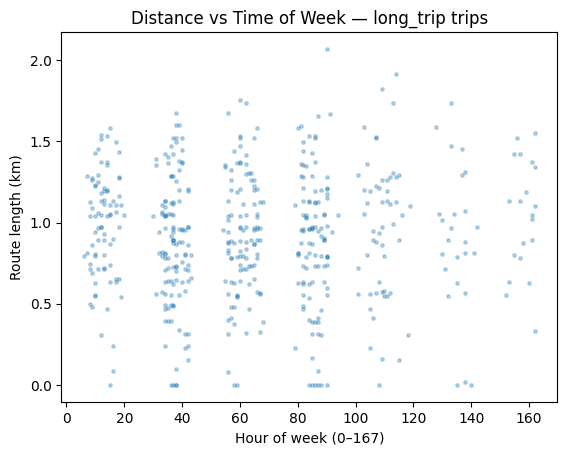

In [10]:
N = 50000
df_plot = df.sample(N, random_state=0) if len(df) > N else df

labels = [lbl for lbl in df["duration_label"].dropna().unique()]
for lbl in labels:
    sub = df_plot[df_plot["duration_label"] == lbl]
    if sub.empty: 
        continue

    # distance vs hour of day
    plt.figure()
    plt.scatter(sub["hour_of_day"], sub["route_length_km"], s=6, alpha=0.3)
    plt.title(f"Distance vs Time of Day — {lbl} trips")
    plt.xlabel("Hour of day (0–23)"); plt.ylabel("Route length (km)")
    plt.show()

    # distance vs hour of week
    plt.figure()
    plt.scatter(sub["hour_of_week"], sub["route_length_km"], s=6, alpha=0.3)
    plt.title(f"Distance vs Time of Week — {lbl} trips")
    plt.xlabel("Hour of week (0–167)"); plt.ylabel("Route length (km)")
    plt.show()


Encode a Simple 'Assumption' Rule & Compare Assumption with Label

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = df.copy()

REQUIRED = ["pickup_datetime", "trip_duration_minutes", "hour_of_day", "day_of_week", "duration_cluster"]
missing = [c for c in REQUIRED if c not in df.columns]
assert not missing, f"Missing columns: {missing}"

# Ensure datetime, drop any rows lacking essentials
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors="coerce")
df = df.dropna(subset=["pickup_datetime", "trip_duration_minutes"]).copy()

# Standardize label column name and type
df["duration_label"] = df["duration_cluster"].astype(str)

In [13]:
# For each hour-of-day, compute the 1/3 and 2/3 quantiles of duration
hour_quantiles = (
    df.groupby("hour_of_day")["trip_duration_minutes"]
      .quantile([1/3, 2/3])
      .unstack()  # columns: 0.333..., 0.667...
      .rename(columns={1/3:"q1", 2/3:"q2"})
)

# Safety: if an hour has very few samples, fall back to global quantiles
global_q1 = df["trip_duration_minutes"].quantile(1/3)
global_q2 = df["trip_duration_minutes"].quantile(2/3)
hour_quantiles = hour_quantiles.fillna({"q1": global_q1, "q2": global_q2})

# Quick peek
hour_quantiles.head()

,q1,q2
hour_of_day,,
0,4.000000,5.966667
1,6.822222,11.838889
2,1.416667,1.650000
3,3.588889,4.294444
4,3.594444,5.022222


In [14]:
# Define morning window for diagnostics/plots later
MORNING_HOURS = set(range(7, 11))  # 7–10 AM

def time_based_assumption(row):
    h = int(row["hour_of_day"])
    # Get hour-specific thresholds (fallback handled by fillna above)
    q1 = hour_quantiles.loc[h, "q1"] if h in hour_quantiles.index else global_q1
    q2 = hour_quantiles.loc[h, "q2"] if h in hour_quantiles.index else global_q2
    d = row["trip_duration_minutes"]

    if d <= q1: 
        return "short_trip"
    if d <= q2: 
        return "medium_trip"
    return "long_trip"

df["assumption_label"] = df.apply(time_based_assumption, axis=1).astype(str)

Row-normalized confusion:
 assumption_label  long_trip  medium_trip  short_trip
duration_label                                      
long_trip          1.000000     0.000000    0.000000
medium_trip        0.362923     0.583333    0.053744
short_trip         0.000845     0.120034    0.879121

Counts:
 assumption_label  long_trip  medium_trip  short_trip
duration_label                                      
long_trip               515            0           0
medium_trip             601          966          89
short_trip                1          142        1040

Overall agreement: 0.752


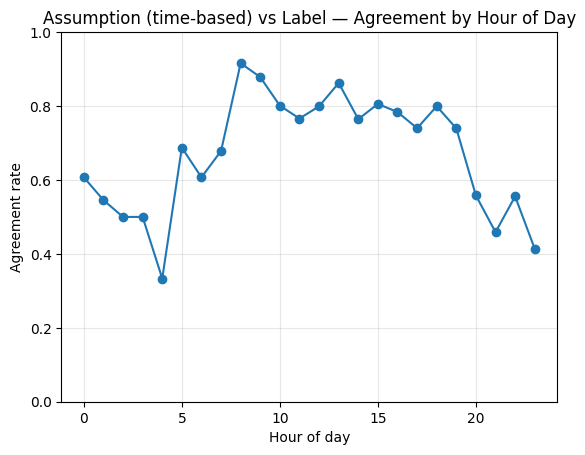

In [15]:
# Confusion (row-normalized)
cm = pd.crosstab(df["duration_label"], df["assumption_label"], normalize="index")
print("Row-normalized confusion:\n", cm)

# Raw counts
print("\nCounts:\n", pd.crosstab(df["duration_label"], df["assumption_label"]))

# Overall agreement
acc = (df["duration_label"] == df["assumption_label"]).mean()
print(f"\nOverall agreement: {acc:.3f}")

# Agreement by hour of day (0..23)
by_hour = (df["duration_label"] == df["assumption_label"]).groupby(df["hour_of_day"]).mean()

plt.figure()
by_hour.plot(marker="o")
plt.title("Assumption (time-based) vs Label — Agreement by Hour of Day")
plt.xlabel("Hour of day"); plt.ylabel("Agreement rate")
plt.ylim(0,1); plt.grid(True, alpha=0.3)
plt.show()

Morning-only agreement (7–10 AM): 0.826


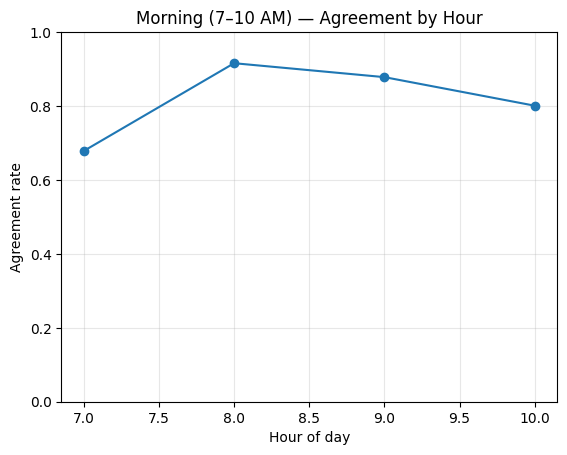

In [16]:
morning_df = df[df["hour_of_day"].isin(MORNING_HOURS)]
morning_acc = (morning_df["duration_label"] == morning_df["assumption_label"]).mean()
print(f"Morning-only agreement (7–10 AM): {morning_acc:.3f}")

plt.figure()
(morning_df["duration_label"] == morning_df["assumption_label"]) \
    .groupby(morning_df["hour_of_day"]).mean().plot(marker="o")
plt.title("Morning (7–10 AM) — Agreement by Hour")
plt.xlabel("Hour of day"); plt.ylabel("Agreement rate")
plt.ylim(0,1); plt.grid(True, alpha=0.3)
plt.show()